In [1]:
import pandas as pd
import geopandas as geo
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('tsa_claims2.csv', low_memory=False)
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


In [6]:
df_cleaned = df.dropna()

In [25]:
# Ensure 'Claim Amount' is a string before cleaning
df_cleaned.loc[:, 'Claim Amount'] = df_cleaned['Claim Amount'].astype(str)

In [27]:
# Remove any non-numeric characters except for the decimal point
df_cleaned.loc[:, 'Claim Amount'] = df_cleaned['Claim Amount'].str.replace(r'[^0-9.]', '', regex=True)

In [29]:
# Now convert 'Claim Amount' to float after cleaning
df_cleaned.loc[:, 'Claim Amount'] = pd.to_numeric(df_cleaned['Claim Amount'], errors='coerce')

In [31]:
# Drop rows where 'Claim Amount' is still NaN after conversion
df_cleaned = df_cleaned.dropna(subset=['Claim Amount'])

In [33]:
# Convert 'Incident Date' column to datetime format 
df_cleaned.loc[:, 'Incident Date'] = pd.to_datetime(df_cleaned['Incident Date'], errors='coerce')

In [34]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 94848 entries, 0 to 145143
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Claim Number   94848 non-null  object 
 1   Date Received  94848 non-null  object 
 2   Incident Date  94730 non-null  object 
 3   Airport Code   94848 non-null  object 
 4   Airport Name   94848 non-null  object 
 5   Airline Name   94848 non-null  object 
 6   Claim Type     94848 non-null  object 
 7   Claim Site     94848 non-null  object 
 8   Item           94848 non-null  object 
 9   Claim Amount   94848 non-null  object 
 10  Status         94848 non-null  object 
 11  Close Amount   94848 non-null  float64
 12  Disposition    94848 non-null  object 
dtypes: float64(1), object(12)
memory usage: 10.1+ MB
None


In [37]:
# Calculate the median and mean claim amount for tsa_claims2.csv
median_claim = df_cleaned['Claim Amount'].median()
mean_claim = df_cleaned['Claim Amount'].mean()

print(f"Typical claim amount (median): ${median_claim:.2f}")
print(f"Typical claim amount (mean): ${mean_claim:.2f}")

# Assuming 'Status' column represents approval status (same as before)
df_cleaned['Status'] = df_cleaned['Status'].str.lower()

# Calculate approval rate
approved_claims = df_cleaned[df_cleaned['Status'].isin(['approved', 'settled'])]
approval_rate = len(approved_claims) / len(df_cleaned) * 100

print(f"Approval rate: {approval_rate:.2f}%")

Typical claim amount (median): $183.69
Typical claim amount (mean): $3634.83
Approval rate: 43.83%


In [39]:
df_cleaned['Close Amount'] = df_cleaned['Close Amount'].astype(str)  # make string
df_cleaned['Close Amount'] = df_cleaned['Close Amount'].str.replace(r'[^0-9.]', '', regex=True)  # Remove unwanted characters
df_cleaned['Close Amount'] = pd.to_numeric(df_cleaned['Close Amount'], errors='coerce')  # Convert to numeric
# Filter out claims with zero 'Claim Amount'
approved_claims = approved_claims[approved_claims['Claim Amount'] != 0]

# Now calculate the percent paid by airports
approved_claims['Percent Paid'] = (approved_claims['Close Amount'] / approved_claims['Claim Amount']) * 100

# Display results
print(approved_claims[['Airport Code', 'Claim Amount', 'Close Amount', 'Percent Paid']].head())

  Airport Code Claim Amount  Close Amount Percent Paid
0          EWR        350.0        350.00        100.0
2          STL       278.88        227.92    81.726908
3          MIA         50.0         50.00        100.0
4          MCO        84.79         84.79        100.0
5          CAK       459.01        227.00     49.45426


In [41]:
# Group by airport and count the number of claims per airport
airport_claims = df_cleaned['Airport Code'].value_counts().head(5)
print(airport_claims)

Airport Code
LAX    4492
JFK    3835
ORD    3620
EWR    3594
MIA    2986
Name: count, dtype: int64


Year
2000.0         90.22
2001.0        342.14
2002.0     161421.01
2003.0    1760979.85
2004.0    2060894.46
2005.0    1434310.31
2006.0    1126322.09
2007.0     809589.75
2008.0     663229.84
2009.0     424077.80
2010.0        364.00
Name: Close Amount, dtype: float64


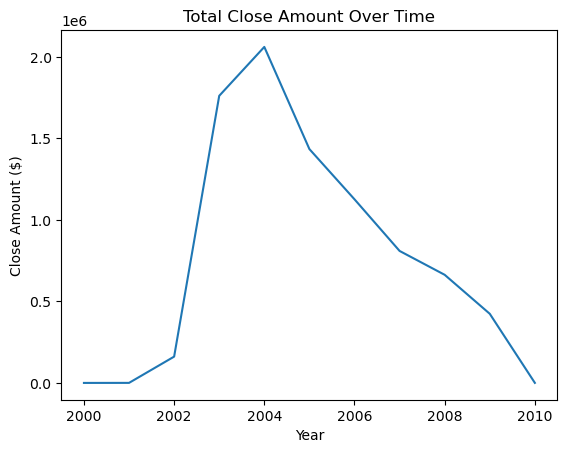

In [43]:
# Group data by year (or by month) to observe trends over time
df_cleaned['Incident Date'] = pd.to_datetime(df_cleaned['Incident Date'], errors='coerce')
df_cleaned['Year'] = df_cleaned['Incident Date'].dt.year

# Sum the close amounts per year
annual_close_amount = df_cleaned.groupby('Year')['Close Amount'].sum()

print(annual_close_amount)

annual_close_amount.plot(kind='line', title='Total Close Amount Over Time', ylabel='Close Amount ($)', xlabel='Year')
plt.show()


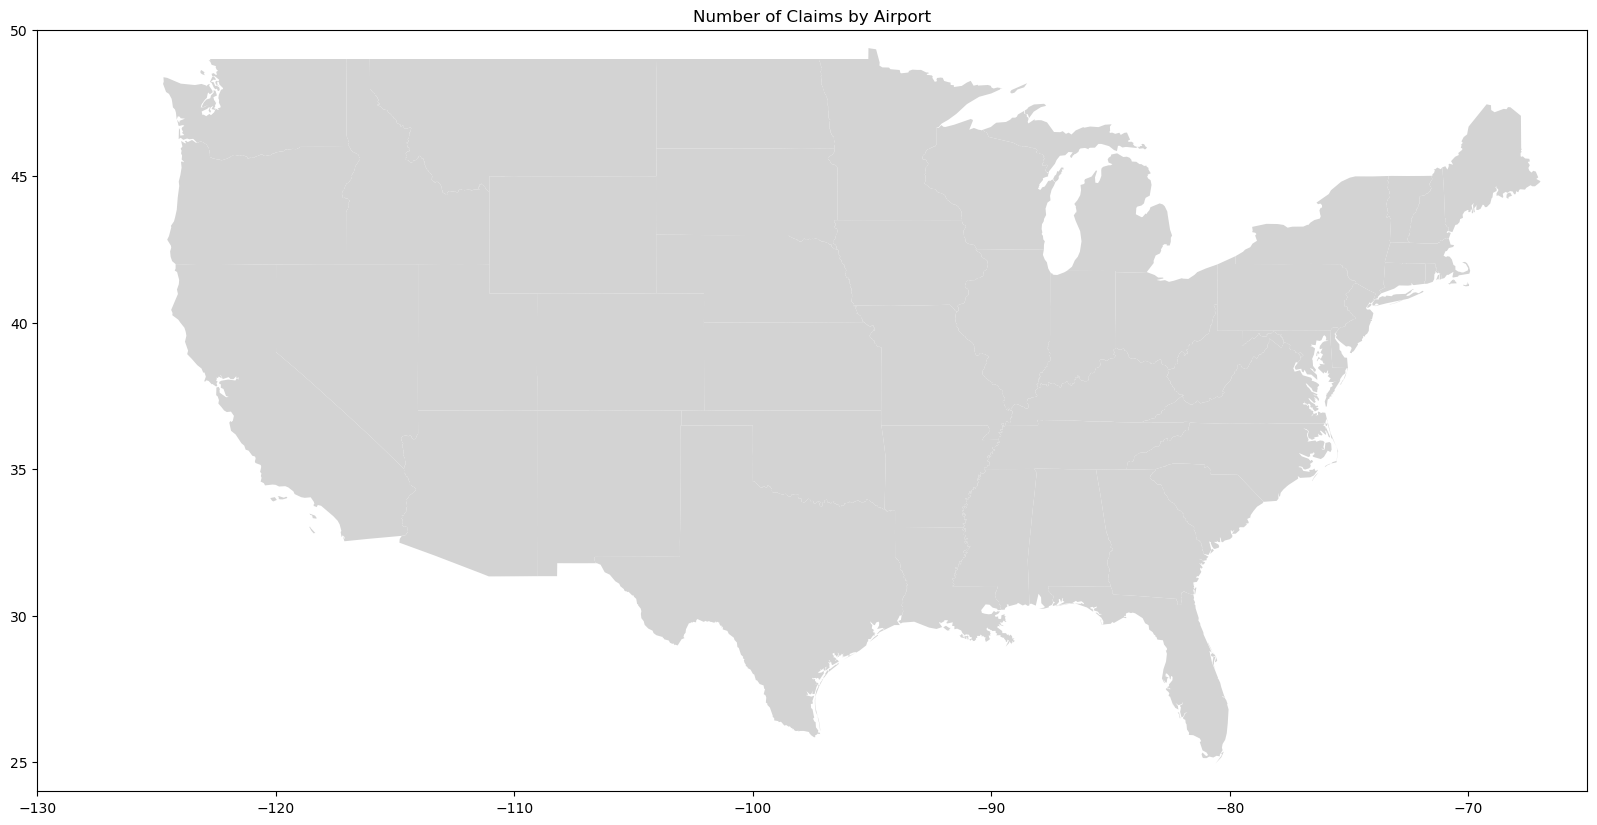

In [189]:
# Load the shape files for the U.S. map 
states = geo.read_file('maps/states.shp')

# Load the global airport database to get airport locations 
airport_data = pd.read_csv('GlobalAirportDatabase.csv')

# Merge the claims data with airport locations based on airport code
merged_data = pd.merge(df_cleaned, airport_data, left_on='Airport Code', right_on='IATACode', how='left')

# Convert the merged data to a GeoDataFrame with the correct CRS
gdf = geo.GeoDataFrame(
    merged_data,
    geometry=geo.points_from_xy(merged_data['LongitudeDegrees'], merged_data['LatitudeDegrees']),
    crs="EPSG:4326" 
)

if gdf.crs != states.crs:
    gdf = gdf.to_crs(states.crs)

# Create a plot
fig, ax = plt.subplots(figsize=(20, 12))
states.plot(ax=ax, color='lightgray')

# Plot markers
gdf.plot(ax=ax, markersize=50, color='blue', alpha=0.7)  

ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])  
    
plt.title('Number of Claims by Airport')
plt.show()

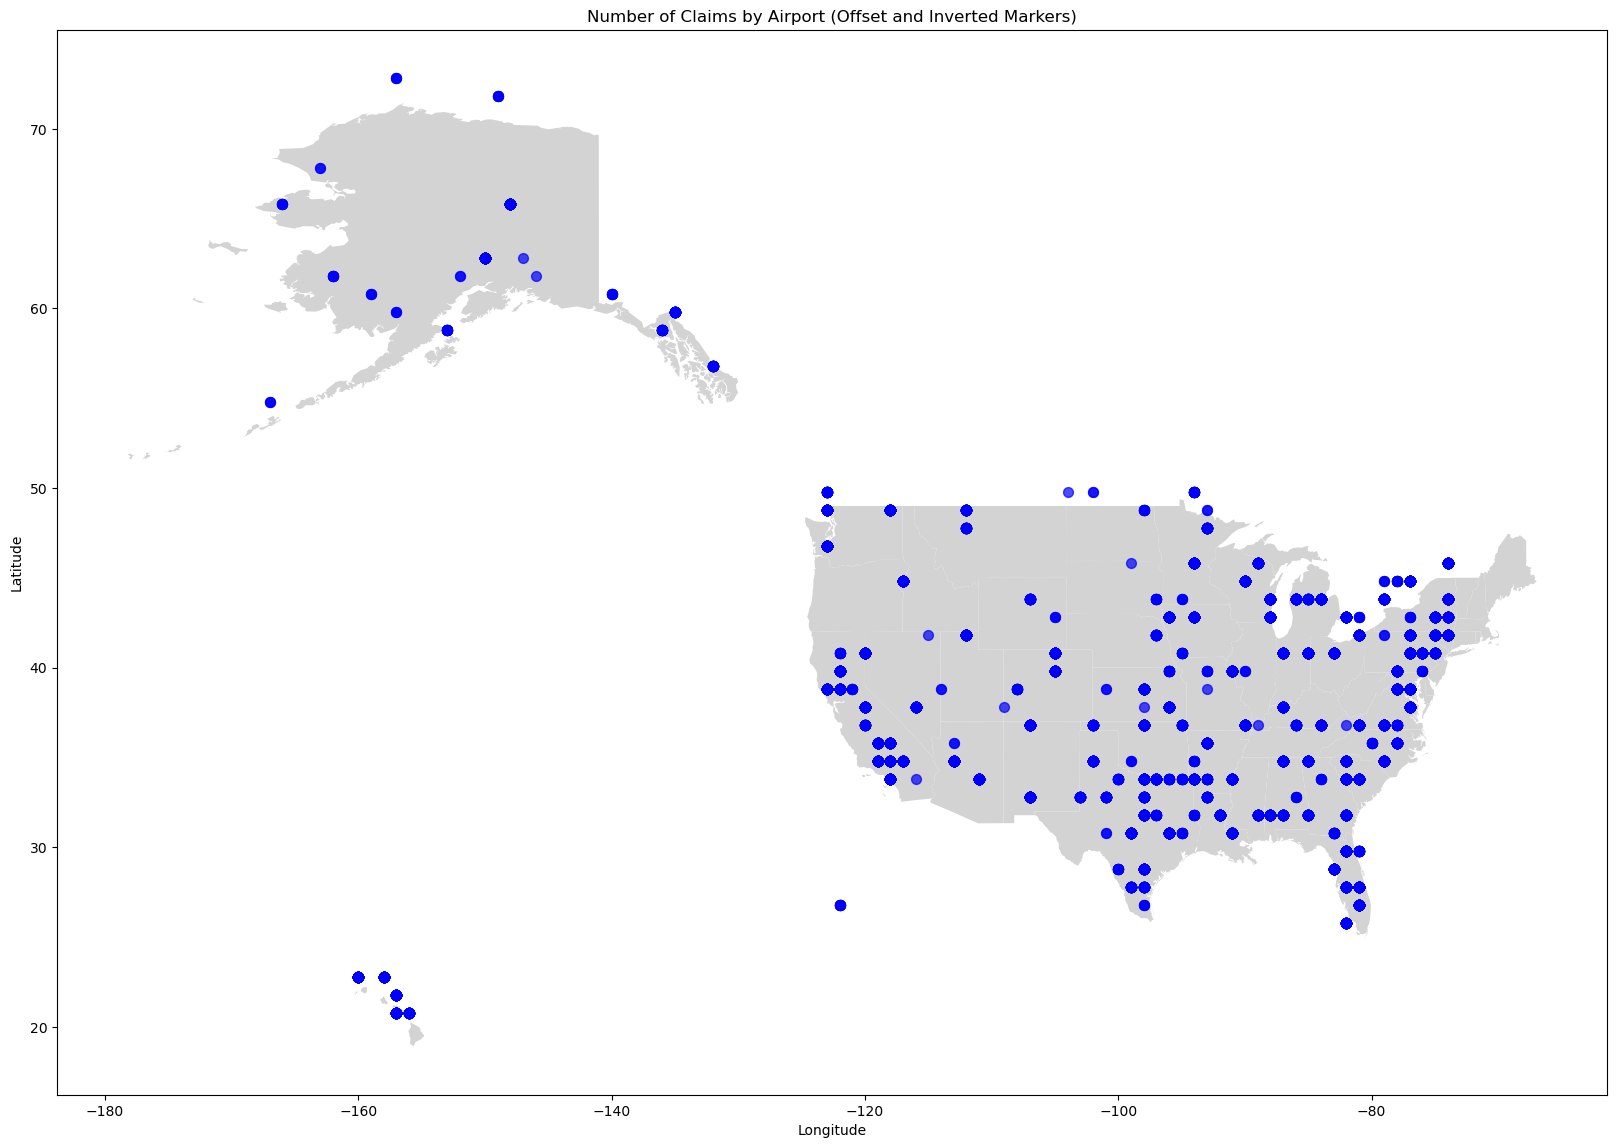

In [299]:
# Load the shape files for the U.S. map
states = geo.read_file('maps/states.shp')

# Load the global airport database
airport_data = pd.read_csv('GlobalAirportDatabase.csv')

# Merge the claims data with airport locations
merged_data = pd.merge(df_cleaned, airport_data, left_on='Airport Code', right_on='IATACode', how='left')

# Convert the merged data to a GeoDataFrame
gdf = geo.GeoDataFrame(
    merged_data,
    geometry=geo.points_from_xy(merged_data['LongitudeDegrees'], merged_data['LatitudeDegrees']),
    crs="EPSG:4326"  # Set the CRS to WGS 84
)

# Reproject to the CRS of the states
gdf = gdf.to_crs(states.crs)

# Filter out markers below y=18
gdf = gdf[gdf['LatitudeDegrees'] >= 18]
gdf = gdf[gdf['LongitudeDegrees'] >= 73]

# Check if the GeoDataFrame is empty
if gdf.empty:
    print("The GeoDataFrame is empty. No markers to plot.")
else:
    # Create a plot
    fig, ax = plt.subplots(figsize=(20, 20))

    # Plot the states
    states.plot(ax=ax, color='lightgray')

    # Calculate the offset (in degrees)
    offset_longitude = -1 # Adjust this value for the desired offset
    offset_latitude = 1.8 # Adjust this value for the desired offset

    # Apply inversion and offset to the marker coordinates
    gdf['AdjustedLongitude'] = -gdf['LongitudeDegrees'] + offset_longitude  # Invert longitude and apply offset
    gdf['AdjustedLatitude'] = gdf['LatitudeDegrees'] + offset_latitude       # Apply offset to latitude

    # Plot the markers using the adjusted coordinates
    ax.scatter(gdf['AdjustedLongitude'], gdf['AdjustedLatitude'], s=50, color='blue', alpha=0.7)



    plt.title('Number of Claims by Airport (Offset and Inverted Markers)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()